# COVID-19 

This is my new version of analyses of COVID-19.  

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from pathlib import Path
import numpy as np
import pandas as pd
import datetime
import time

# Canada

In [2]:
from src.phac import PHAC


can = PHAC()
as_of = "2020-10-20"

In [3]:
can.df

,date,location,total_cases,total_deaths,total_tests,population,total_cases_per_million,total_deaths_per_million,total_tests_per_thousand,new_cases,new_cases_per_million,new_deaths,new_deaths_per_million,new_tests,new_tests_per_thousand
0,2020-01-31,Ontario,3,0.0,NaN,14711827.0,0.203918,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-31,British Columbia,1,0.0,NaN,5110917.0,0.195660,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-31,Canada,4,0.0,NaN,37742157.0,0.105982,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-08,Ontario,3,0.0,NaN,14711827.0,0.203918,0.000000,NaN,0.0,0.000000,0.0,0.00000,0.0,0.000000
4,2020-02-08,British Columbia,4,0.0,NaN,5110917.0,0.782638,0.000000,NaN,3.0,0.586979,0.0,0.00000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3396,2020-10-19,Prince Edward Island,63,0.0,43530.0,158158.0,398.335841,0.000000,275.231098,0.0,0.000000,0.0,0.00000,124.0,0.784026
3397,2020-10-19,Yukon,17,0.0,3751.0,41078.0,413.846828,0.000000,91.314085,2.0,48.687862,0.0,0.00000,34.0,0.827694
3398,2020-10-19,Northwest Territories,5,0.0,5057.0,44904.0,111.348655,0.000000,112.618030,0.0,0.000000,0.0,0.00000,82.0,1.826118
3399,2020-10-19,Nunavut,0,0.0,2785.0,39097.0,0.000000,0.000000,71.233087,0.0,0.000000,0.0,0.00000,18.0,0.460393


## Total Cases

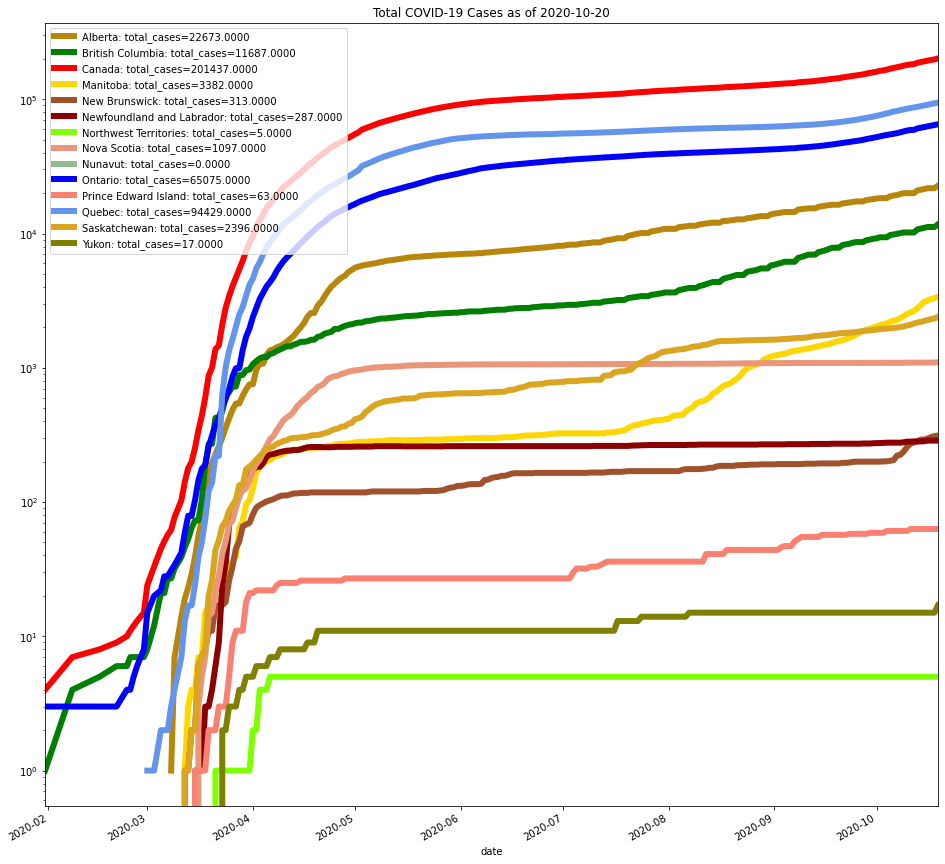

In [4]:
can_tc_fig = can.plot_var("total_cases", *can.provinces,
    figsize=(16,16),
    log_scale=True,
    colours=can.prov_colours,
    #date_start="2020-03-01",
    lw=6,
    title=f"Total COVID-19 Cases as of {as_of}"  
)


plt.show()

In [5]:
var_pivot = can.var_by_location("total_cases", *can.provinces)
var_pivot[-7:][can.provinces]

location,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2020-10-13,186881.0,283.0,63.0,1092.0,284.0,87791.0,60692.0,2779.0,2174.0,20956.0,10734.0,15.0,5.0,0.0
2020-10-14,189387.0,283.0,63.0,1092.0,292.0,88994.0,61413.0,2925.0,2199.0,21199.0,10892.0,15.0,5.0,0.0
2020-10-15,191732.0,284.0,63.0,1092.0,292.0,89963.0,62196.0,3098.0,2232.0,21443.0,11034.0,15.0,5.0,0.0
2020-10-16,194106.0,287.0,63.0,1093.0,297.0,91018.0,62908.0,3173.0,2270.0,21775.0,11189.0,15.0,5.0,0.0
2020-10-17,196321.0,287.0,63.0,1095.0,305.0,92297.0,63713.0,3258.0,2306.0,21775.0,11189.0,15.0,5.0,0.0
2020-10-18,198148.0,287.0,63.0,1097.0,310.0,93391.0,64371.0,3302.0,2330.0,21775.0,11189.0,15.0,5.0,0.0
2020-10-19,201437.0,287.0,63.0,1097.0,313.0,94429.0,65075.0,3382.0,2396.0,22673.0,11687.0,17.0,5.0,0.0


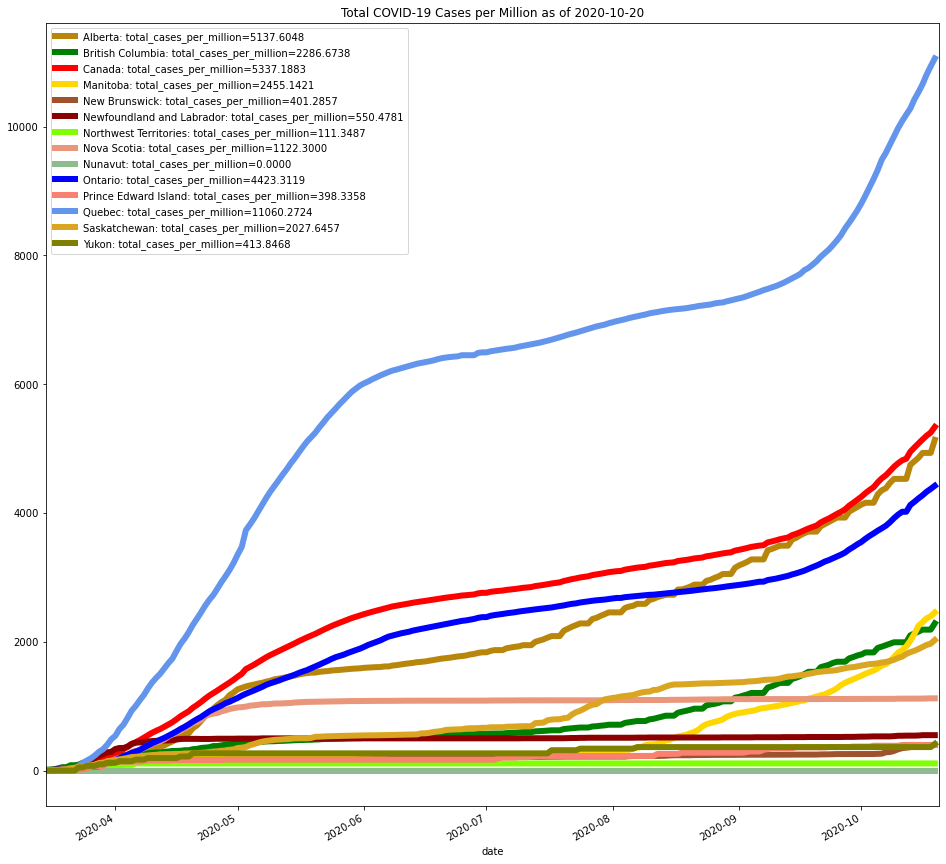

In [6]:
can_tcpm_fig = can.plot_var("total_cases_per_million", *can.provinces,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-03-15",
    date_end=as_of,
    lw=6,
    title=f"Total COVID-19 Cases per Million as of {as_of}"  
)


plt.show()

## New cases

In [7]:
can.prov_colours

{'Canada': 'r',
 'Newfoundland and Labrador': 'darkred',
 'Prince Edward Island': 'salmon',
 'Nova Scotia': 'darksalmon',
 'New Brunswick': 'sienna',
 'Quebec': 'cornflowerblue',
 'Ontario': 'b',
 'Manitoba': 'gold',
 'Saskatchewan': 'goldenrod',
 'Alberta': 'darkgoldenrod',
 'British Columbia': 'g',
 'Yukon': 'olive',
 'Northwest Territories': 'chartreuse',
 'Nunavut': 'darkseagreen'}

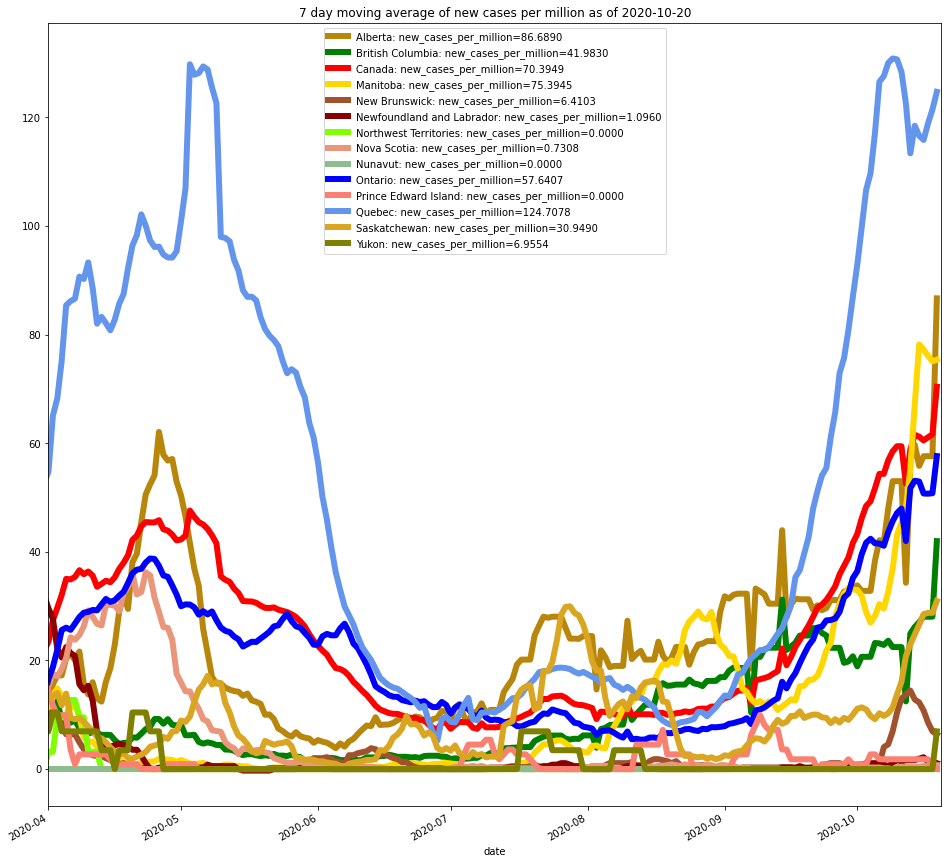

In [8]:
ma_win = 7
can_nc_fig = can.plot_var("new_cases_per_million", *can.provinces, ma_window=ma_win,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-04-01",
    date_end=as_of,
    lw=6,
    title=f"{ma_win} day moving average of new cases per million as of {as_of}"                     
)

#savefile = f"{as_of}_COVID-19_NCperMil_{ma_win}_days.png"
#plt.savefig(Path.home().joinpath("Documents/COVID/" + savefile),
#           format="png")


plt.show()

In [9]:
can_nc = can.var_by_location("new_cases", *can.provinces)
can_nc[-15:][can.provinces]

location,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2020-10-05,2804.0,0.0,0.0,0.0,2.0,1191.0,615.0,51.0,9.0,578.0,358.0,0.0,0.0,0.0
2020-10-06,2363.0,0.0,0.0,0.0,2.0,1364.0,548.0,55.0,16.0,276.0,102.0,0.0,0.0,0.0
2020-10-07,1800.0,0.0,0.0,0.0,17.0,900.0,583.0,32.0,10.0,143.0,115.0,0.0,0.0,0.0
2020-10-08,2436.0,0.0,0.0,0.0,3.0,1078.0,797.0,66.0,18.0,364.0,110.0,0.0,0.0,0.0
2020-10-09,2558.0,2.0,0.0,0.0,13.0,1102.0,939.0,84.0,22.0,277.0,119.0,0.0,0.0,0.0
2020-10-10,2062.0,3.0,0.0,3.0,20.0,1097.0,809.0,96.0,34.0,0.0,0.0,0.0,0.0,0.0
2020-10-11,1685.0,0.0,2.0,0.0,14.0,942.0,649.0,54.0,24.0,0.0,0.0,0.0,0.0,0.0
2020-10-12,975.0,1.0,0.0,0.0,6.0,843.0,0.0,77.0,48.0,0.0,0.0,0.0,0.0,0.0
2020-10-13,4042.0,0.0,0.0,0.0,6.0,815.0,1553.0,124.0,34.0,961.0,549.0,0.0,0.0,0.0


In [10]:
can_nt = can.var_by_location("new_tests", *can.provinces)


pd.DataFrame({"new_cases": can_nc["Quebec"], "new_tests": can_nt["Quebec"]}, index=can_nt.index)[-7:]

,new_cases,new_tests
date,,
2020-10-13,815.0,0.0
2020-10-14,1203.0,22045.0
2020-10-15,969.0,0.0
2020-10-16,1055.0,24995.0
2020-10-17,1279.0,12756.0
2020-10-18,1094.0,11209.0
2020-10-19,1038.0,9279.0


## Active Confirmed Cases

In [11]:
can.active_confirmed_cases(*can.provinces)[-7:]

location,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
date,,,,,,,,,,,,,,
2020-10-13,3047.0,1721.0,29920.0,826.0,84.0,10.0,0.0,5.0,0.0,9607.0,4.0,14341.0,275.0,0.0
2020-10-14,3137.0,1754.0,30629.0,932.0,92.0,9.0,0.0,4.0,0.0,9703.0,4.0,14706.0,286.0,0.0
2020-10-15,3208.0,1814.0,31197.0,1069.0,92.0,9.0,0.0,4.0,0.0,9948.0,4.0,14742.0,305.0,0.0
2020-10-16,3418.0,1808.0,31447.0,1101.0,97.0,12.0,0.0,4.0,0.0,9928.0,4.0,14745.0,330.0,0.0
2020-10-17,3418.0,1808.0,31850.0,1150.0,104.0,11.0,0.0,6.0,0.0,10080.0,4.0,14917.0,352.0,0.0
2020-10-18,3418.0,1808.0,31992.0,1162.0,109.0,10.0,0.0,8.0,0.0,10172.0,2.0,14932.0,371.0,0.0
2020-10-19,3738.0,1948.0,32477.0,1191.0,110.0,10.0,0.0,8.0,0.0,10261.0,2.0,14779.0,428.0,2.0


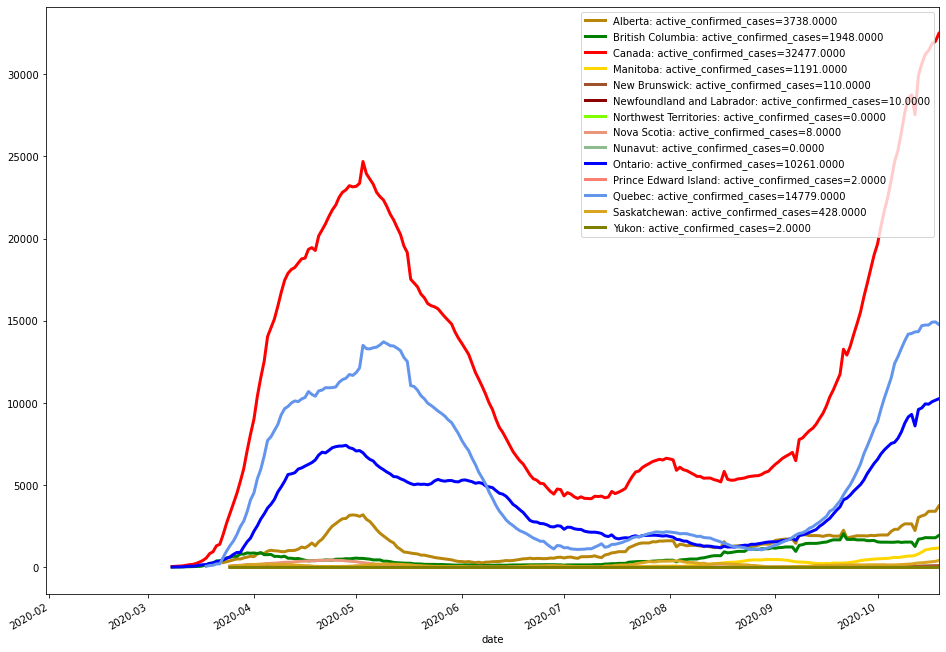

In [12]:
fig = can.plot_var("active_confirmed_cases", *can.provinces,
                   colours=can.prov_colours)

plt.show()

In [13]:
can.active_confirmed_cases(*can.provinces, percapita=True)[-7:]

location,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
date,,,,,,,,,,,,,,
2020-10-13,690.437162,336.730180,792.747484,599.629623,107.693274,19.180421,0.0,5.115315,0.0,653.012029,25.291165,1679.731505,232.722275,0.000000
2020-10-14,710.830777,343.186947,811.532844,676.579672,117.949776,17.262379,0.0,4.092252,0.0,659.537391,25.291165,1722.483196,242.031166,0.000000
2020-10-15,726.919073,354.926523,826.582328,776.033980,117.949776,17.262379,0.0,4.092252,0.0,676.190659,25.291165,1726.699801,258.110160,0.000000
2020-10-16,774.504175,353.752565,833.206221,799.264183,124.360090,23.016505,0.0,4.092252,0.0,674.831209,25.291165,1727.051185,279.266730,0.000000
2020-10-17,774.504175,353.752565,843.883936,834.835432,133.334530,21.098463,0.0,6.138377,0.0,685.163032,25.291165,1747.197187,297.884512,0.000000
2020-10-18,774.504175,353.752565,847.646307,843.546758,139.744844,19.180421,0.0,8.184503,0.0,691.416505,12.645582,1748.954106,313.963506,0.000000
2020-10-19,847.014805,381.144910,860.496659,864.599130,141.026907,19.180421,0.0,8.184503,0.0,697.466059,12.645582,1731.033534,362.200486,48.687862


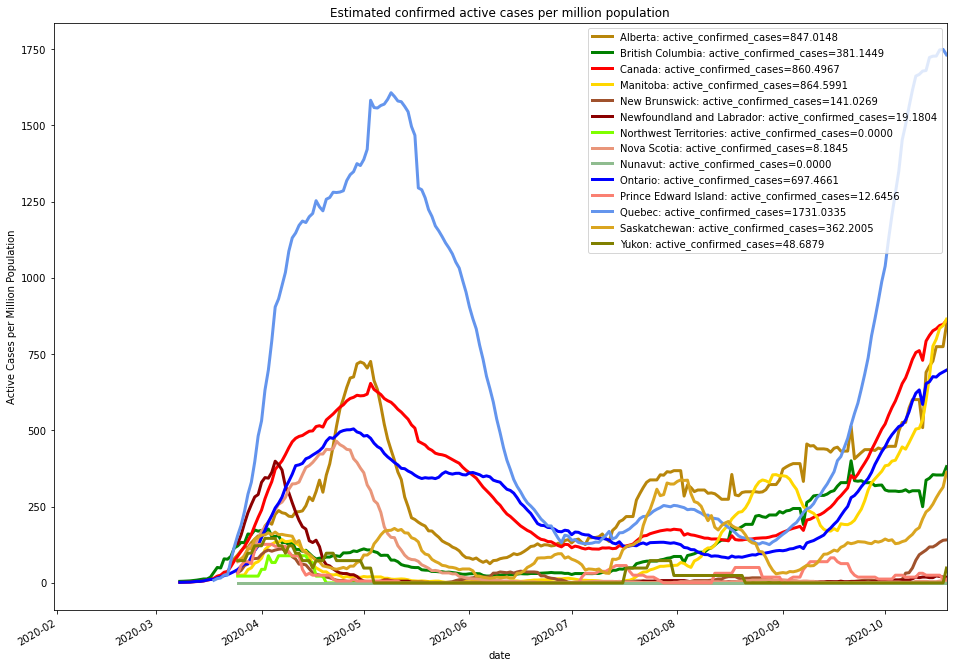

In [14]:
fig = can.plot_var("active_confirmed_cases", *can.provinces, percapita=True,
                   colours=can.prov_colours,
                  title=f"Estimated confirmed active cases per million population",
                  y_label="Active Cases per Million Population")

plt.show()

## Tests

In [15]:
ma_win = 28

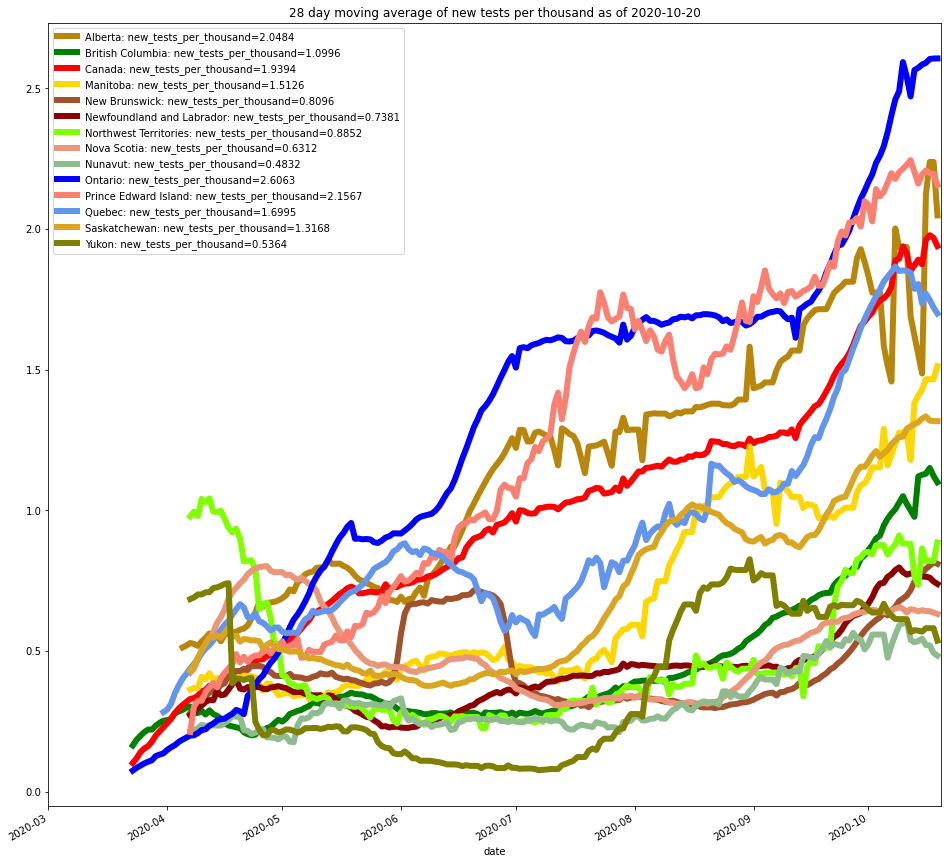

In [16]:

can_nt_fig = can.plot_var("new_tests_per_thousand", *can.provinces, ma_window=ma_win,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-03-01",
    date_end=as_of,
    lw=6,
    title=f"{ma_win} day moving average of new tests per thousand as of {as_of}"  
)


plt.show()

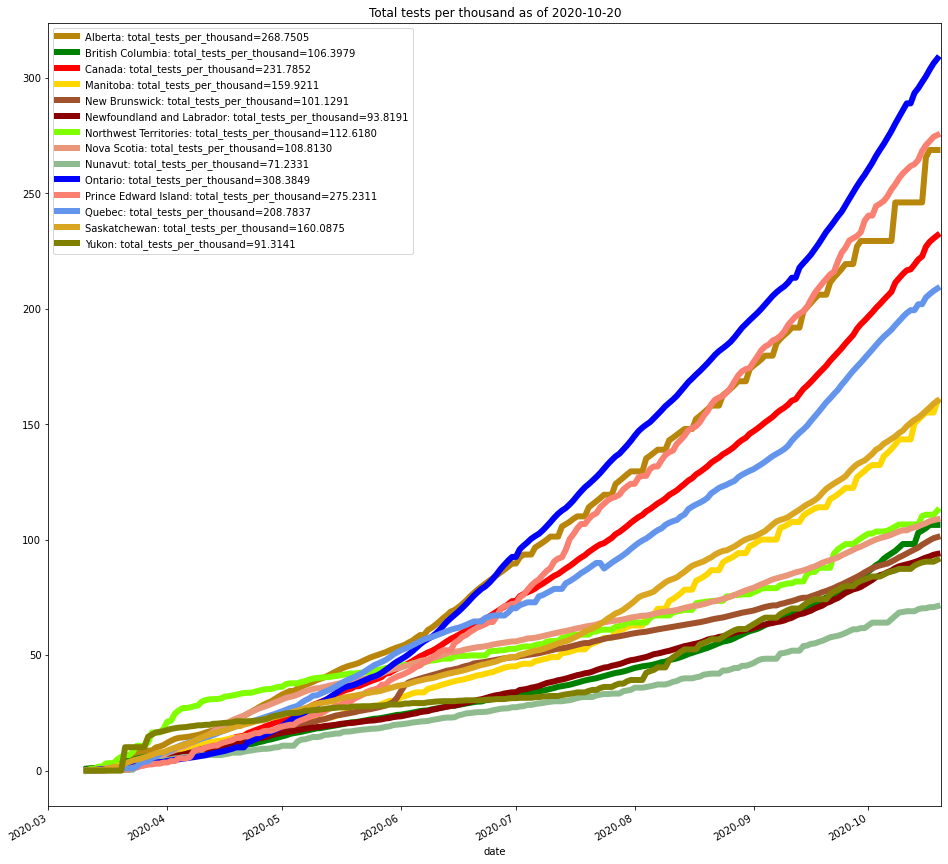

In [17]:
can_ttpt_fig = can.plot_var("total_tests_per_thousand", *can.provinces,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-03-01",
    date_end=as_of,
    lw=6,
    title=f"Total tests per thousand as of {as_of}"  
)


plt.show()

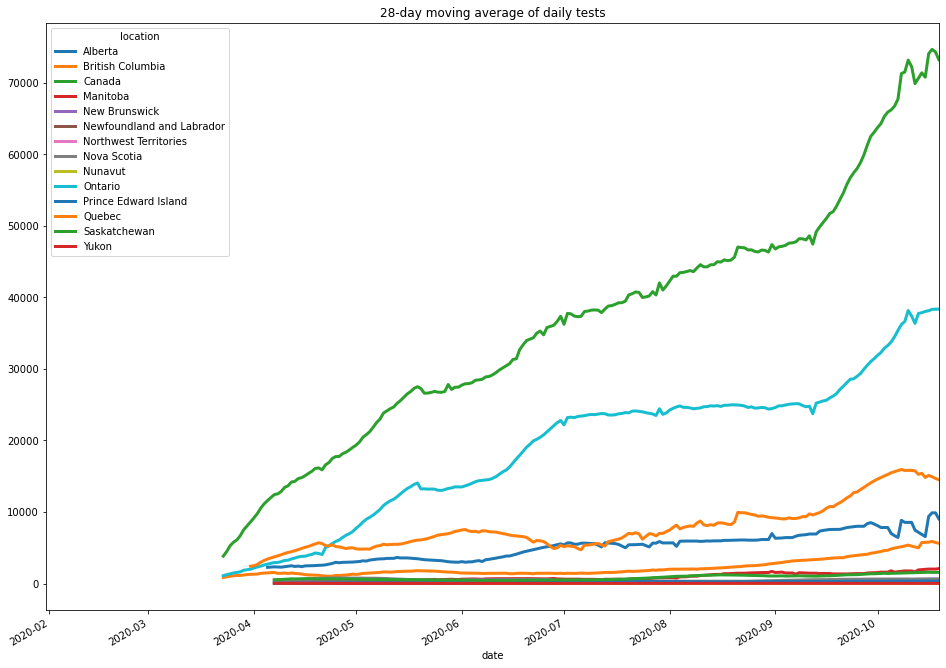

In [18]:
# Plot Daily Tests - Use Average over last ma_win days
ma_win = 28
locations = can.provinces

can_nt = can.var_by_location("new_tests", *locations).rolling(ma_win).mean()

start_date = can_nt.index[0]
end_date = can_nt.index[-1]

plot_properties = dict(
    figsize=(16,12),
    xlim=(start_date, end_date),
    logy=False,
    lw=3,
    #color=[can.prov_colours[loc] for loc in locations],
    title=f"{ma_win}-day moving average of daily tests",
)

fig = can_nt.plot(**plot_properties)

#legend_labels = [f"{loc}: Daily Tests={can_nt.to_dict()[loc][max(can_nt[:end_date].index)]:.4f}"
#                 for loc in sorted(locations)]
#plt.legend(legend_labels)

plt.show()

## Positive Test Rate

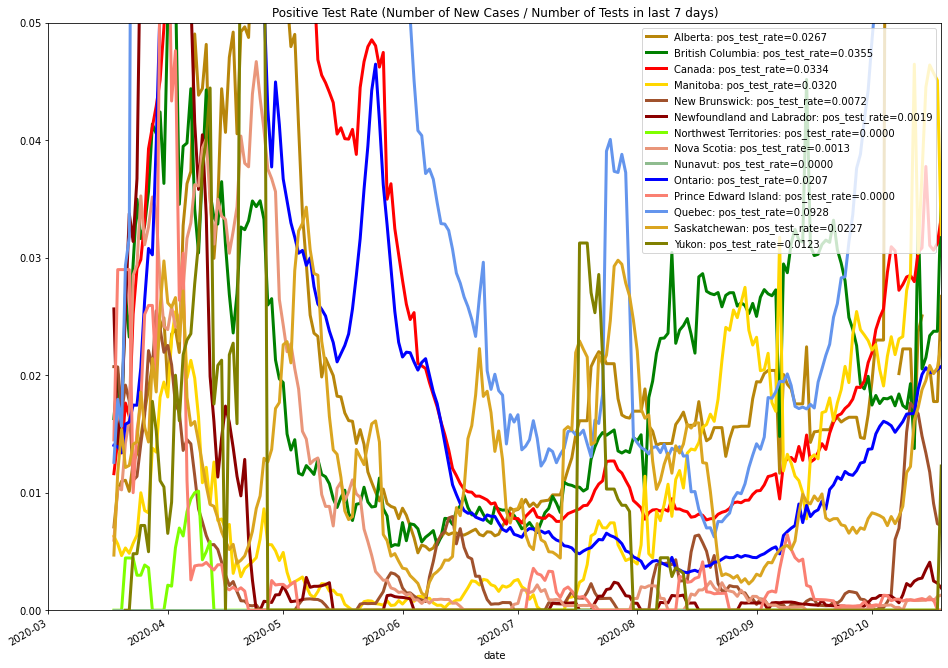

In [19]:
# Plot the positive test rate over the last ma_win days
ma_win = 7
locations = can.provinces


ax = can.plot_var("pos_test_rate", *can.provinces,
                   ma_window=ma_win,
                   date_start="2020-03-01",
                   colours=can.prov_colours,
                   title=f"Positive Test Rate (Number of New Cases / Number of Tests in last {ma_win} days)")

ax.set_ylim(0,0.05)

plt.show()

(0.0, 0.2)

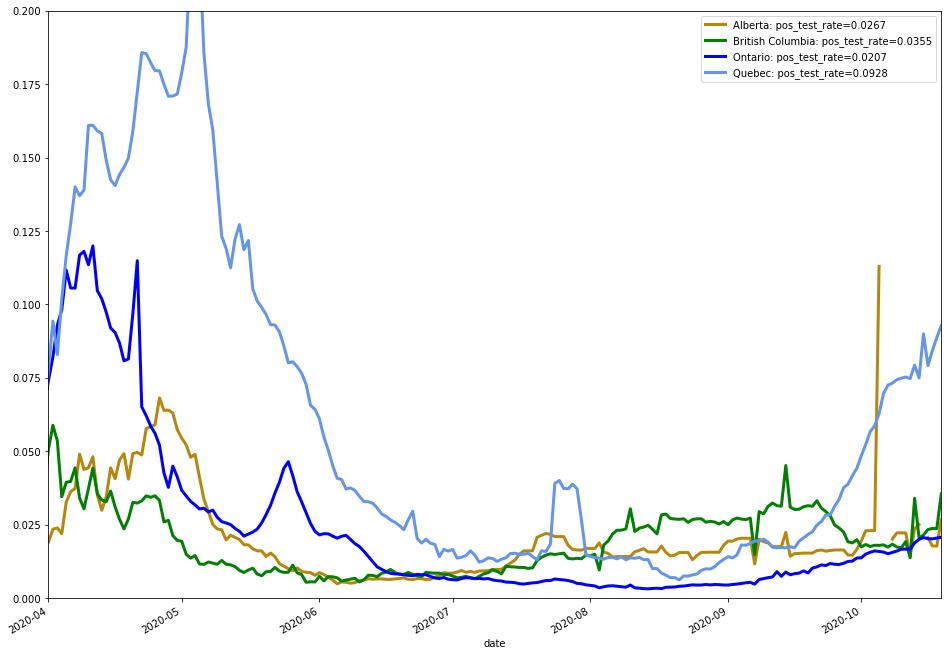

In [20]:
ax = can.plot_var("pos_test_rate", "British Columbia", "Ontario", "Quebec", "Alberta", ma_window=ma_win, 
             date_start="2020-04-01",
             colours=can.prov_colours,
             #log_scale=True
            )

ax.set_ylim(0,0.20)

In [21]:
can.pos_test_rate(ma_win, *can.provinces)[-14:]

location,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
date,,,,,,,,,,,,,,
2020-10-06,inf,0.018156,0.030934,0.023276,0.001313,0.001198,0.0,0.000447,0.0,0.015700,0.000808,0.069704,0.007973,0.00000
2020-10-07,inf,0.017395,0.030587,0.021749,0.006019,0.000948,0.0,0.000233,0.0,0.015141,0.000931,0.072546,0.007363,0.00000
2020-10-08,0.020135,0.018403,0.027227,0.023082,0.006972,0.000630,0.0,0.000241,0.0,0.015590,0.000933,0.073210,0.007979,0.00000
2020-10-09,0.022239,0.017416,0.027714,0.023288,0.010287,0.001299,0.0,0.000000,0.0,0.016049,0.000781,0.074393,0.008836,0.00000
2020-10-10,0.022239,0.017158,0.028364,0.027213,0.015160,0.002268,0.0,0.000780,0.0,0.016689,0.000893,0.074888,0.011721,0.00000
2020-10-11,0.022239,0.019281,0.028488,0.028652,0.017631,0.002047,0.0,0.000903,0.0,0.016726,0.000857,0.075294,0.012223,0.00000
2020-10-12,0.014392,0.013759,0.027963,0.046465,0.017166,0.002469,0.0,0.000825,0.0,0.016737,0.000835,0.074770,0.016187,0.00000
2020-10-13,0.023692,0.034014,0.030483,0.030348,0.016720,0.002661,0.0,0.000823,0.0,0.018818,0.000918,0.079351,0.017249,0.00000
2020-10-14,0.025050,0.020531,0.030834,0.037139,0.014821,0.002732,0.0,0.000840,0.0,0.020063,0.000991,0.074967,0.018764,0.00000


In [22]:
def prob_exposure(group_size, ptr, isolation_compliance=0.8):
    return 1 - np.power(1 - ptr + isolation_compliance * ptr, group_size)

today = datetime.datetime.today().strftime('%Y-%m-%d')
group_sizes = {
    "British Columbia": [("2020-05-08", 50, 50), ("2020-06-23", 50, 50), (today, 50, 50)]
}

group_size = 10
can_pe = can.pos_test_rate(ma_win, *can.provinces).apply(lambda ptr: prob_exposure(group_size, ptr))

can_pe[-7:]




location,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
date,,,,,,,,,,,,,,
2020-10-13,0.046386,0.065983,0.059321,0.059065,0.032940,0.005309,0.0,0.001646,0.0,0.037004,0.001835,0.147835,0.033968,0.000000
2020-10-14,0.048985,0.040311,0.059985,0.071844,0.029250,0.005451,0.0,0.001678,0.0,0.039410,0.001979,0.140211,0.036901,0.000000
2020-10-15,NaN,0.042176,0.073008,0.085533,0.026437,0.006902,0.0,0.001697,0.0,0.040515,0.001756,0.166086,0.038413,0.000000
2020-10-16,0.040591,0.045761,0.060377,0.089014,0.023254,0.008137,0.0,0.002293,0.0,0.039775,0.001769,0.147561,0.040883,0.000000
2020-10-17,0.034951,0.046475,0.059614,0.087753,0.018020,0.004959,0.0,0.001556,0.0,0.039683,0.001813,0.156371,0.039539,0.000000
2020-10-18,0.034951,0.046475,0.060722,0.086606,0.014617,0.004595,0.0,0.002327,0.0,0.040236,0.000000,0.163944,0.040501,0.000000
2020-10-19,0.052163,0.068797,0.064866,0.062121,0.014304,0.003764,0.0,0.002572,0.0,0.040724,0.000000,0.170897,0.044551,0.024271


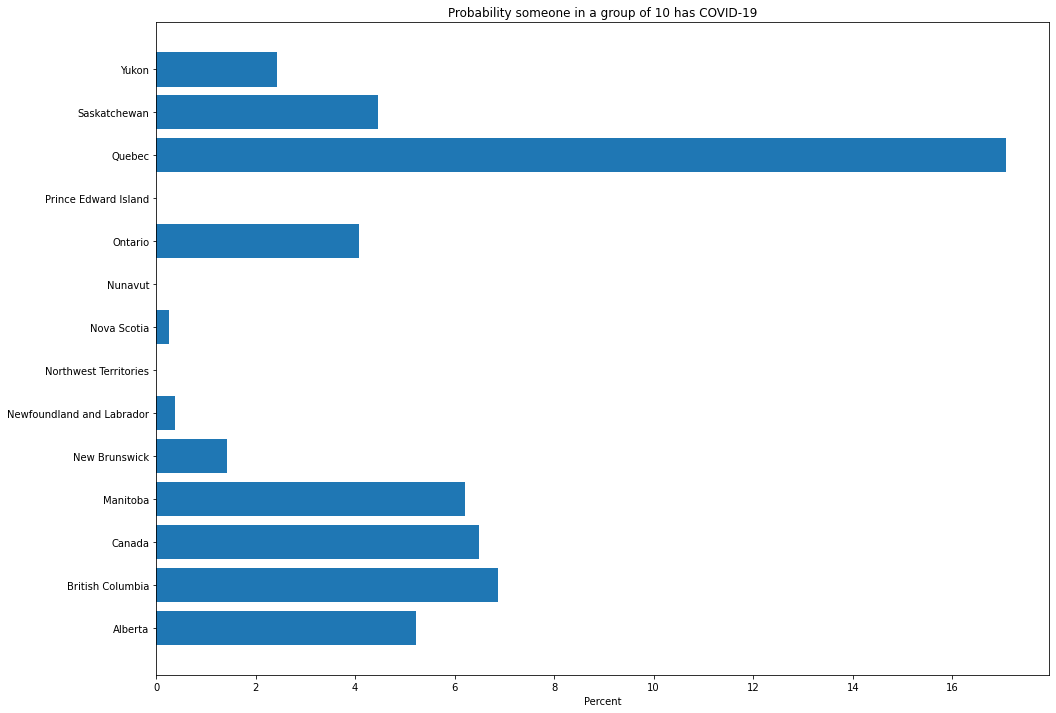

In [23]:
pe_fig, pe_ax = plt.subplots(figsize=(16,12))

pe_ax.barh(list(can_pe.columns), 100 * can_pe[-1:].values[0])
pe_ax.set_xlabel("Percent")
pe_ax.set_title(f"Probability someone in a group of {group_size} has COVID-19")

# savefile = f"{as_of}_COVID-19_ProbExp_{group_size}.png"
# plt.savefig(Path.home().joinpath("Downloads/" + savefile),
#           format="png")

plt.show()

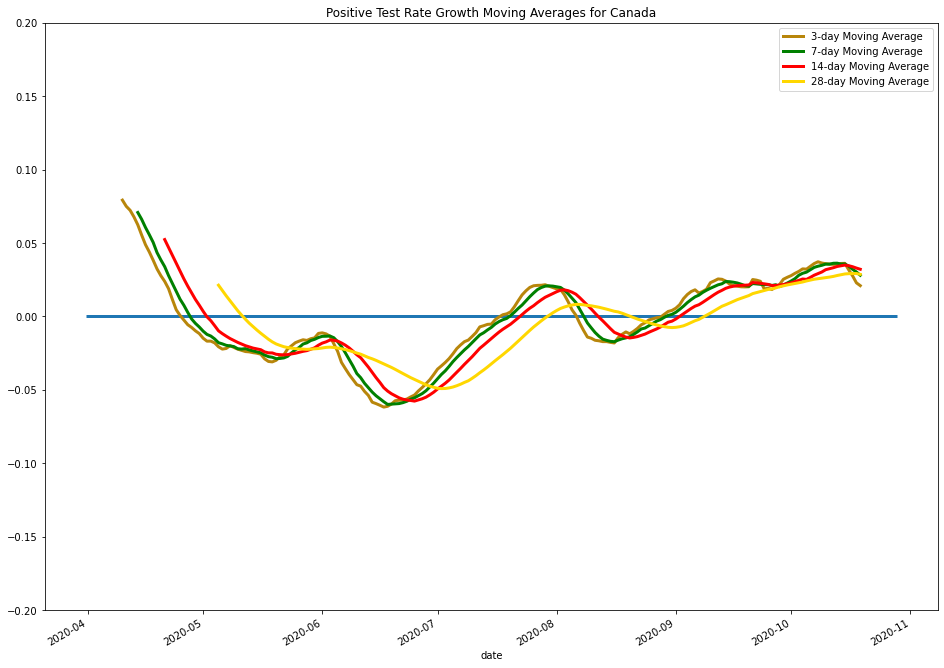

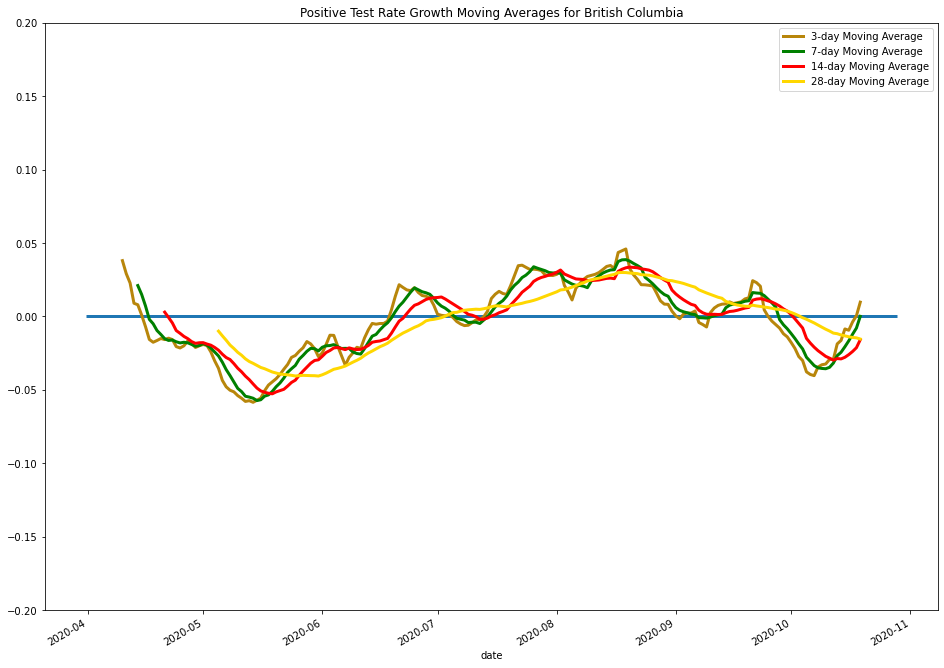

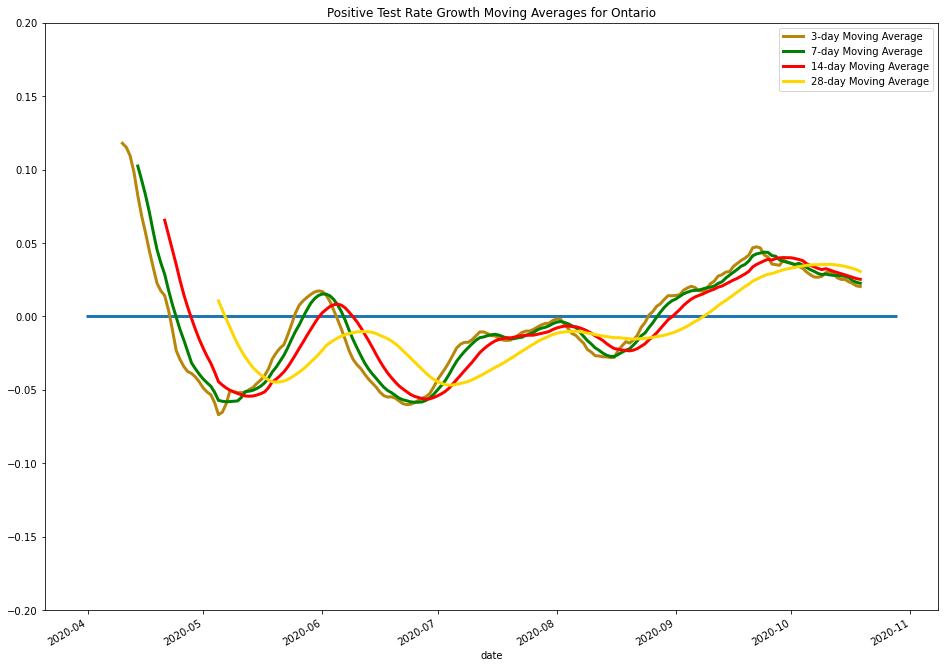

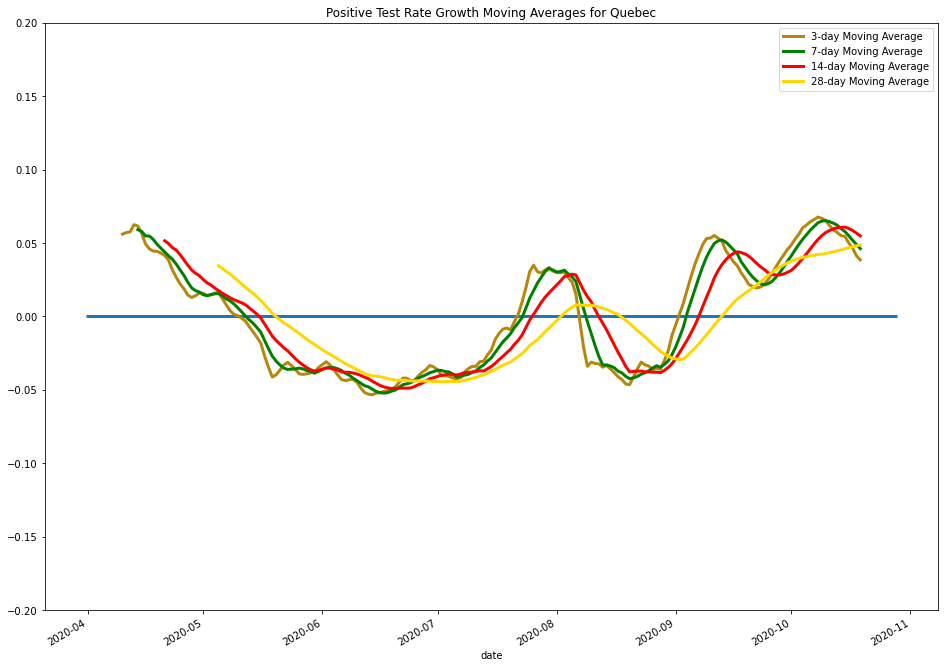

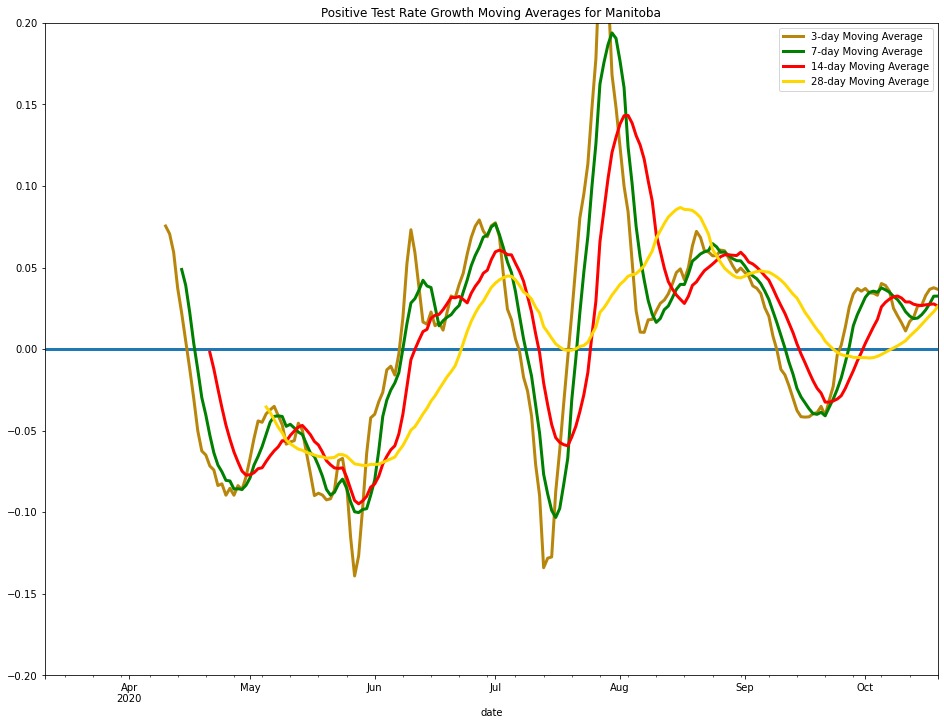

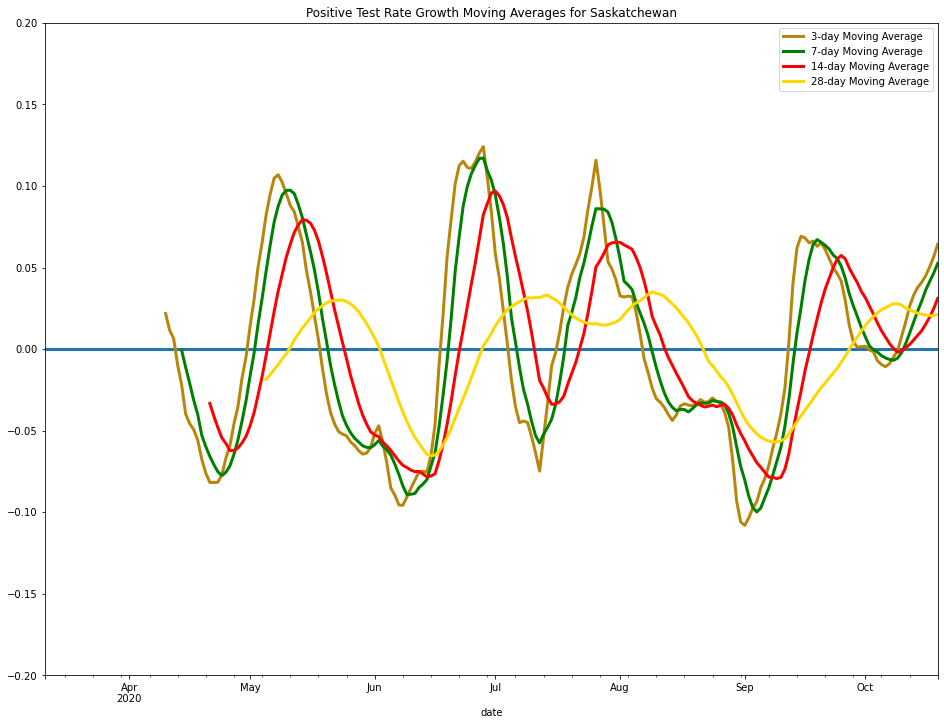

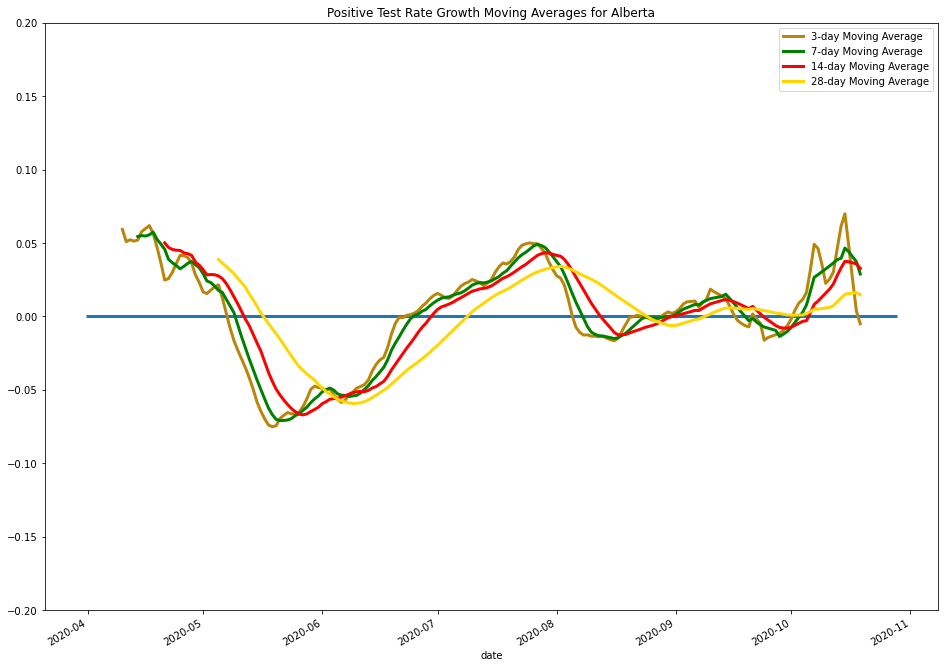

In [24]:
# can.large_provinces + can.prairies
for location in (can.large_provinces + can.prairies):

    pt_rate_growth = can.growth_rate("pos_test_rate", 14, location)

    pt_rate_growth_ma = pd.DataFrame.from_dict(
        {f"{window}-day Moving Average": pt_rate_growth.rolling(window).mean()[location] 
         for window in [3,7, 14, 28]}
    )


    ax = pt_rate_growth_ma.plot(
        figsize=(16,12),
        color=[can.prov_colours[loc] for loc in sorted(locations)],
        lw = 3, 
        title=f"Positive Test Rate Growth Moving Averages for {location}"
    )
    
    ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], lw=3)
    ax.set_ylim((-0.2,0.2))
    
    
#    savefile = f"{as_of}_PTGRMAs_{location}.png"
#    plt.savefig(Path.home().joinpath("Documents/COVID/" + savefile),
#                format="png")


In [25]:
can.growth_rate("pos_test_rate", 14, *can.provinces)[-60:]

/Users/bill/IdeaProjects/covid-19/src/dataset.py:195: RuntimeWarning: invalid value encountered in power
  growth = lambda x: np.power(x, 1 / window)


location,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
date,,,,,,,,,,,,,,
2020-08-21,0.000069,0.024253,-0.006852,0.064227,0.048392,-0.051923,NaN,0.017158,NaN,-0.012139,NaN,-0.030157,-0.030479,-1.0
2020-08-22,0.000069,0.023387,-0.006618,0.061767,0.044447,-0.048346,NaN,0.029907,NaN,-0.008061,NaN,-0.033196,-0.036737,-1.0
2020-08-23,0.000069,0.017205,-0.003602,0.052590,0.051192,-0.002667,NaN,0.042909,NaN,-0.002013,NaN,-0.029997,-0.029500,-1.0
2020-08-24,-0.001078,0.023964,-0.002724,0.057203,0.051933,-1.000000,NaN,0.040082,NaN,-0.002125,NaN,-0.035593,-0.023749,-1.0
2020-08-25,-0.003110,0.022448,-0.000699,0.061975,0.038477,-1.000000,NaN,0.037742,NaN,0.006745,NaN,-0.035883,-0.042739,-1.0
2020-08-26,-0.003315,0.015761,-0.001578,0.062896,0.020382,-1.000000,NaN,0.040687,NaN,0.005307,-0.049265,-0.036930,-0.033127,-1.0
2020-08-27,-0.001353,0.009394,-0.000318,0.055923,-0.010606,-1.000000,NaN,0.040909,NaN,0.008531,-0.051701,-0.033265,-0.040893,-1.0
2020-08-28,0.003071,0.006795,0.000368,0.048736,-0.005849,-0.050600,NaN,0.065441,NaN,0.012077,-0.051002,-0.037292,-0.069090,-1.0
2020-08-29,0.003071,0.008975,0.004336,0.048619,-0.061389,-0.050162,NaN,0.012243,NaN,0.014238,-0.042270,-0.019973,-0.094042,-1.0


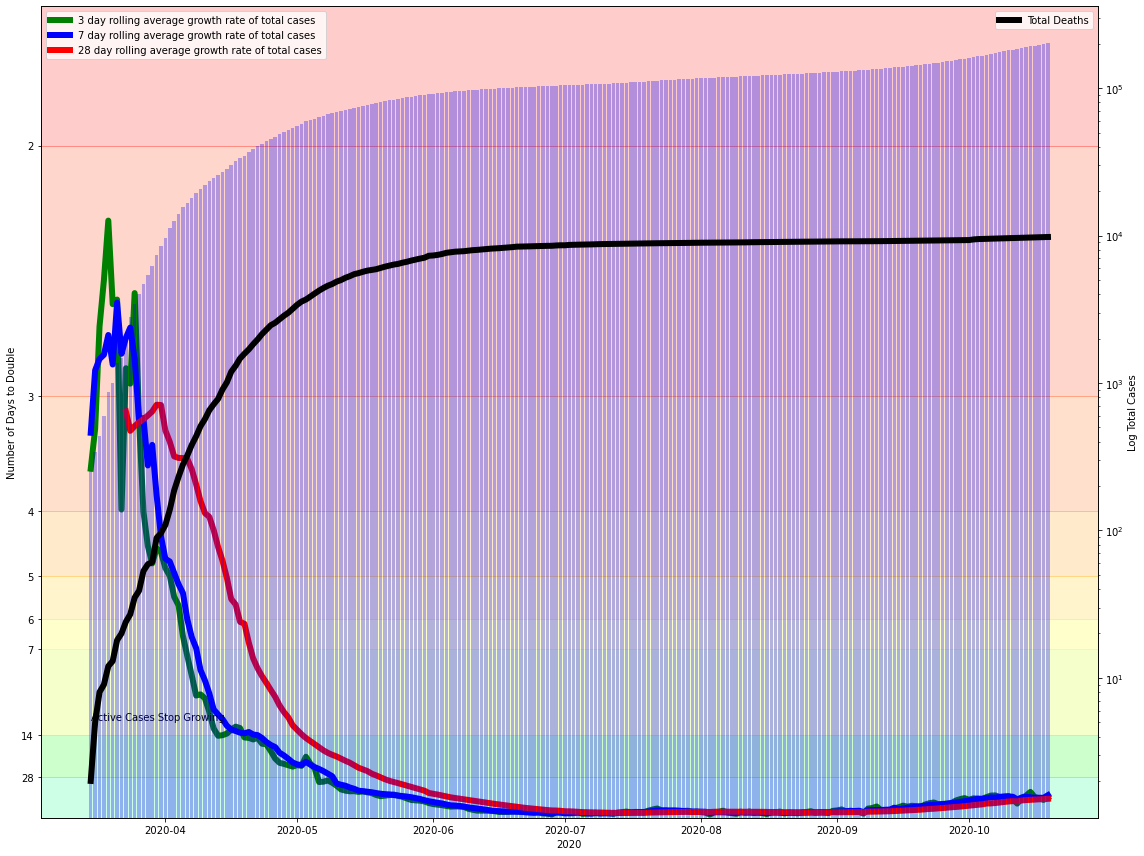

In [32]:
fig = can.plot_location('Canada', from_date="2020-03-15")

plt.show()

# World

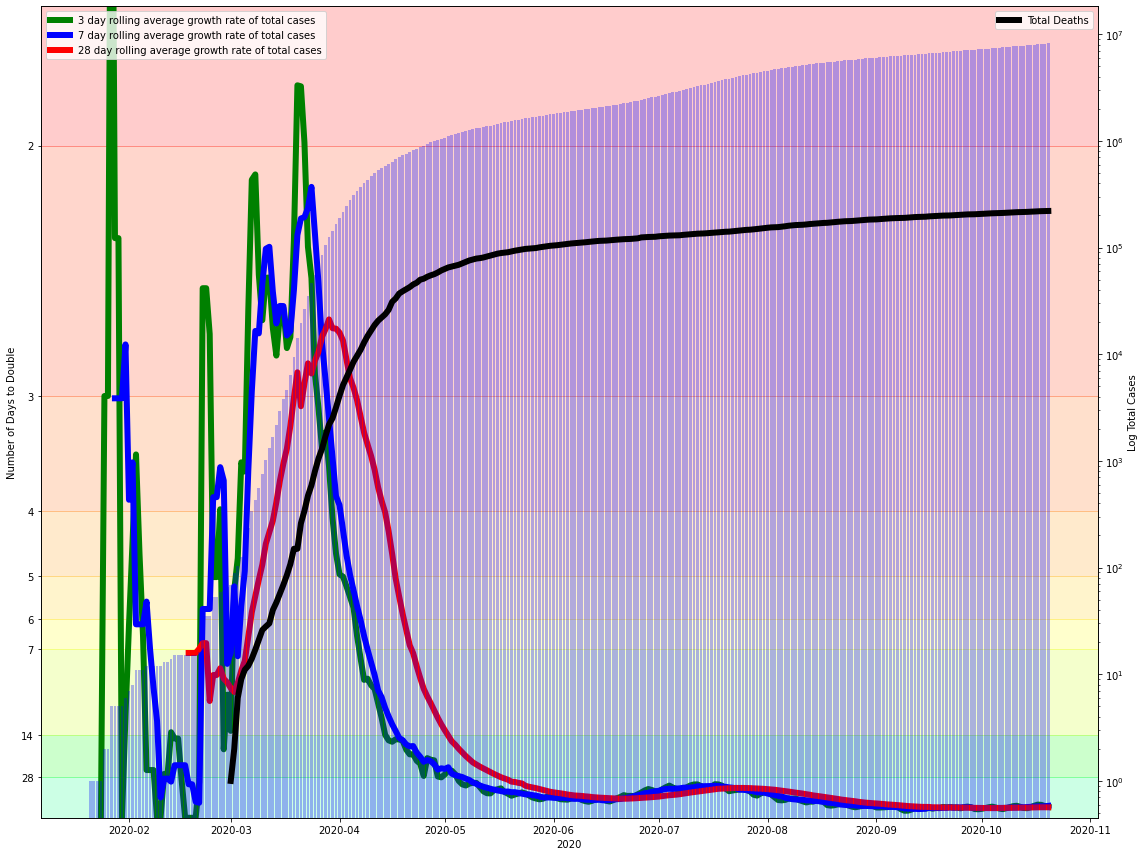

In [27]:
from src.ecdc import ECDC

world = ECDC()
fig = world.plot_location('United States')

plt.show()

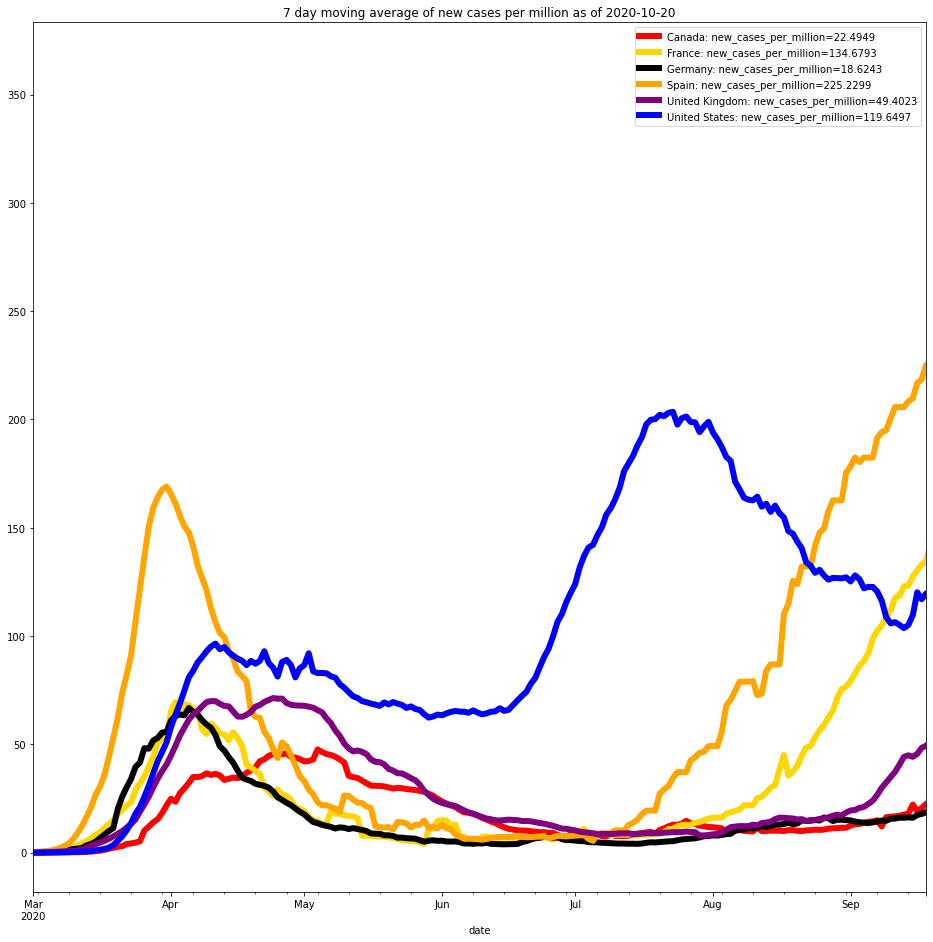

In [28]:
ma_win = 7
us_nc_fig = world.plot_var("new_cases_per_million", 
                           'Spain', 'United States','Canada', 'France', 'Germany', 'United Kingdom',
                           ma_window=ma_win,
    figsize=(16,16),
    #log_scale=True,
    date_start="2020-03-01",
    date_end="2020-09-18",
    colours={'Spain': 'orange', 
             'United States': 'blue', 
             'Canada': 'red', 
             'France': 'gold', 
             'Germany': 'black',
             'United Kingdom': 'purple'},
    lw=6,
    title=f"{ma_win} day moving average of new cases per million as of {as_of}"  
)

#savefile = f"{as_of}_US_CAN_NC_{ma_win}-Day_MA.png"
#plt.savefig(Path.home().joinpath("Documents/COVID/" + savefile),
#           format="png")

plt.show()

In [29]:
world.df.loc[world.df["location"].apply(lambda loc: "spain" in loc.lower())]

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
14566,ESP,Europe,Spain,2019-12-31,NaN,0.0,NaN,NaN,0.0,NaN,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.891
14567,ESP,Europe,Spain,2020-01-01,NaN,0.0,NaN,NaN,0.0,NaN,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.891
14568,ESP,Europe,Spain,2020-01-02,NaN,0.0,NaN,NaN,0.0,NaN,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.891
14569,ESP,Europe,Spain,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.891
14570,ESP,Europe,Spain,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14855,ESP,Europe,Spain,2020-10-15,921374.0,13318.0,10435.714,33553.0,140.0,123.571,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.891
14856,ESP,Europe,Spain,2020-10-16,936560.0,15186.0,10778.286,33775.0,222.0,120.857,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.891
14857,ESP,Europe,Spain,2020-10-17,936560.0,0.0,10778.286,33775.0,0.0,120.857,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.891
14858,ESP,Europe,Spain,2020-10-18,936560.0,0.0,10778.286,33775.0,0.0,120.857,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.891


<AxesSubplot:xlabel='date'>

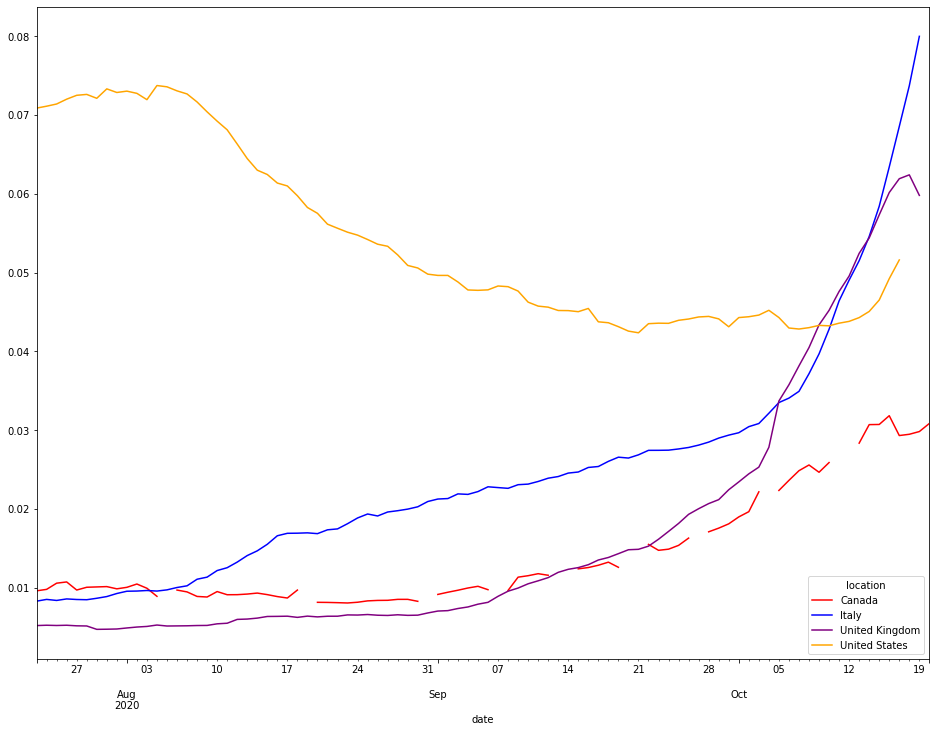

In [30]:
# Plot the positive test rate over the last ma_win days
ma_win = 14
locations = ['Canada', 'United States', 'United Kingdom', 'Italy']

world_pt_rate = world.pos_test_rate(ma_win, *locations, )

world_pt_rate[-90:].plot(figsize=(16,12),color=["red", "blue", 'purple', 'orange'])

#savefile = f"{as_of}_US_CAN_PT_rate.png"
#plt.savefig(Path.home().joinpath("Documents/COVID/" + savefile),
#           format="png")